In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from scipy import ndimage
import pylab as pl
from matplotlib import collections  as mc
import time
import pandas as pd

In [43]:
def show_extracted(img_path,piece_type):
    counts = pd.read_csv('./../datasets/landmark_counts_8.csv')
    fig,axs = plt.subplots(2,4)
    fig.set_figheight(20)
    fig.set_figwidth(30)

    img = cv.imread(img_path,0)
#     img = img[31:-1,1:-1]
    img[500:,:] = 0
    img = img [:,:450]
    trhesh,img = cv.threshold(img, 240,1, cv.THRESH_BINARY)
    binarized =np.where((img==0)|(img==1), img^1, img)
    template = cv.imread(f"./tans/{piece_type}.png",0)
    template = template[3:,3:]
    t2,template = cv.threshold(template, 100,1, cv.THRESH_BINARY)
    nonzero = template.nonzero()
    #creating the proper templates at rotations
    templates = [template[min(nonzero[0]) - 2:max(nonzero[0]) + 2, min(nonzero[1]) - 2:max(nonzero[1]) + 2]]
    for r in range(-45,-360,-45):
        
        rotated= ndimage.rotate(template,r)
        nonzero = rotated.nonzero()
        rotated= rotated[min(nonzero[0])-2:max(nonzero[0])+2,min(nonzero[1])-2:max(nonzero[1])+2]
        templates.append(rotated)

    available_placements =[]
    
    image_edges = cv.Canny(img,100,200)
    
    
    #for ti,ax in zip(range(len(templates)),axs.ravel()):
    for ti in range(len(templates)):
        print(ti)
        image_edges = cv.Canny(img*255,100,200)
        
        _,image_edges_b = cv.threshold(image_edges, 100,1, cv.THRESH_BINARY)
        image_edges|=binarized
        current = templates[ti]
        template_edges = cv.Canny(current*255,100,200)
        _,template_edges_b = cv.threshold(template_edges, 100,1, cv.THRESH_BINARY)
        h, w = current.shape[:2]

        method = cv.TM_SQDIFF

        res = cv.matchTemplate(image_edges_b, template_edges_b, method, mask=  current)
    
        i=0
        attempt =0    
        
        while i < 5 and attempt <7:
            min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
            
            xt = min_loc[1] - h // 2 if min_loc[1] > 20 else 0
            xb = min_loc[1] + h // 2 + 1
            yl = min_loc[0] - w // 2 if min_loc[0] > 20 else 0
            yr = min_loc[0] + w // 2 + 1
            
            res[xt:xb, yl:yr] = float('inf')
            
            part = img[min_loc[1]:min_loc[1] + h, min_loc[0]:min_loc[0] + w]
            #print(f'{h*w}: {min_val}, {min_loc}')
            if np.count_nonzero(np.bitwise_xor(np.bitwise_and(part, current), current)) < 50:
                
                print(f'{min_val/np.sum(current != 0)}at {(min_loc[1] + 2, min_loc[0] + w // 2)}')
                cv.rectangle(image_edges,(min_loc[0],min_loc[1]), (min_loc[0]+w+1, min_loc[1]+h+1), 255 )
                available_placements.append((min_loc,ti*45))
                i+=1
                
            attempt+=1
        image_edges[20:20+h,20:20+w]=templates[ti]*255 
        ax_img=axs.ravel()[ti]
        #ax_tmp=axs.ravel()[2*ti+1]
        ax_img.imshow(image_edges,cmap='gray')
        #ax_tmp.imshow(templates[ti]*255,cmap='gray')
    return available_placements,binarized

0
1
2
3
4
5
6
7


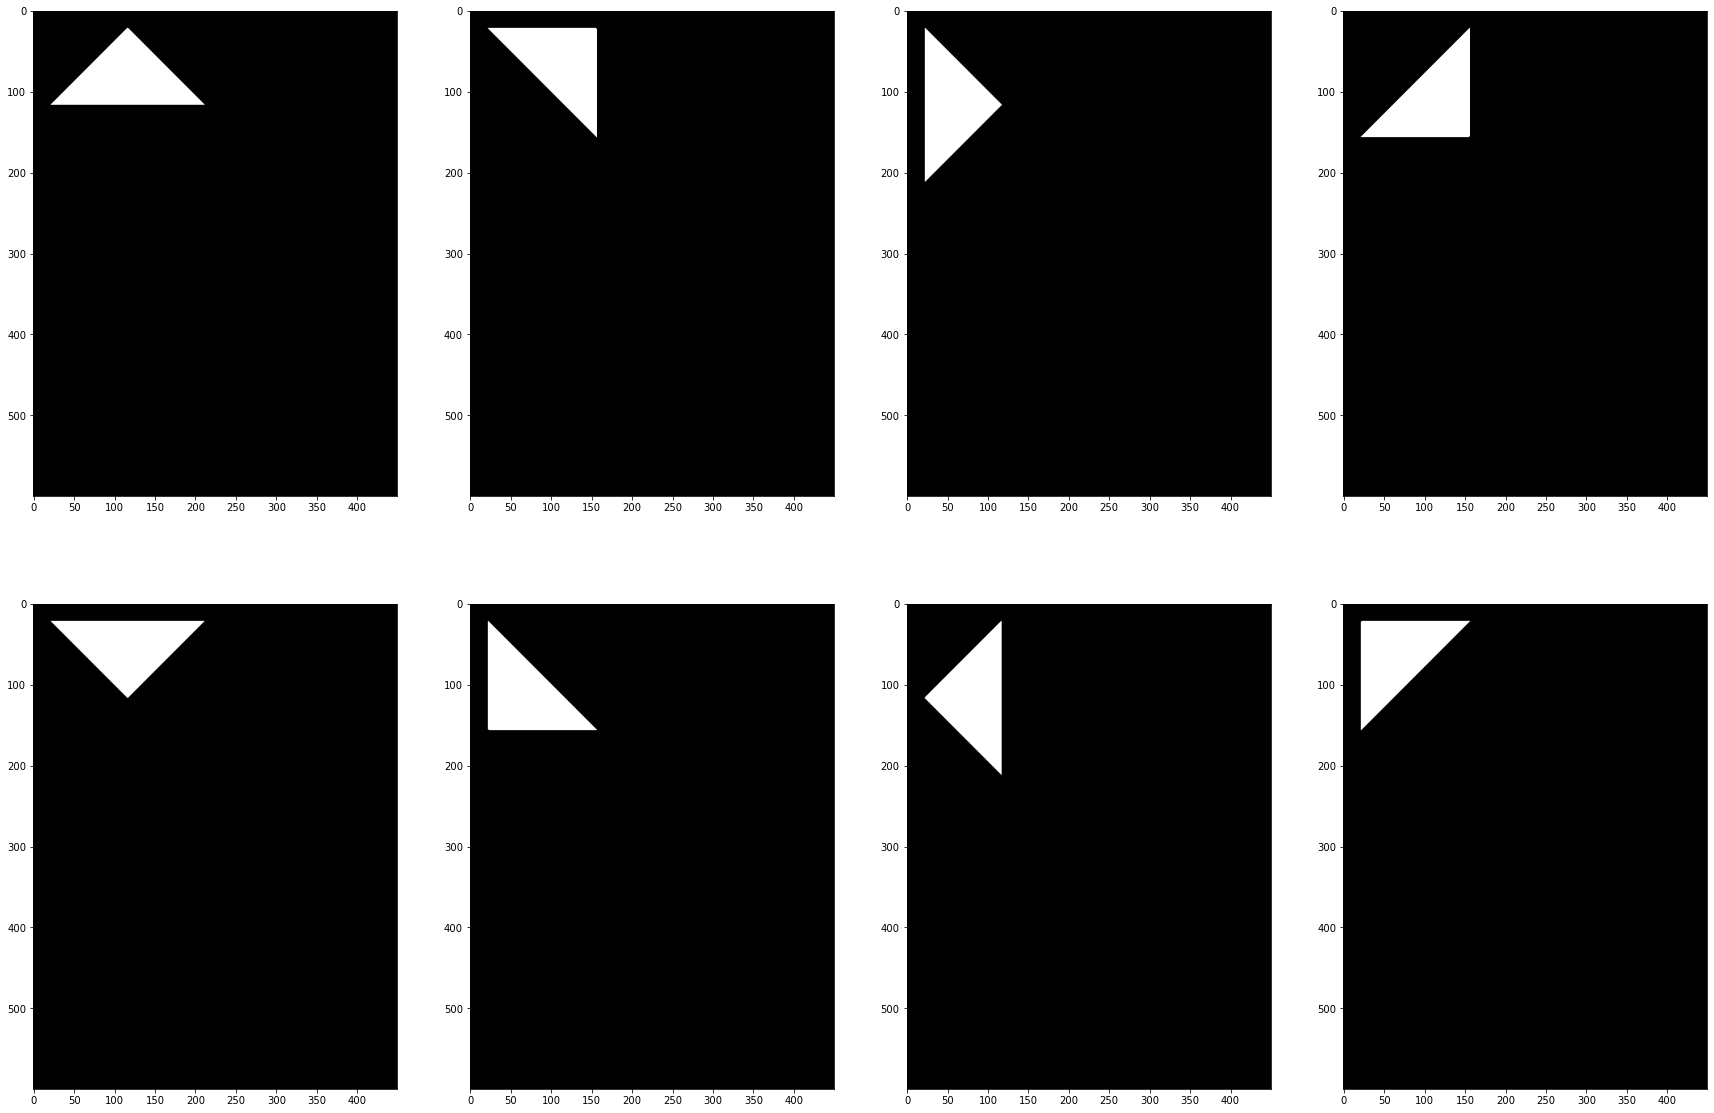

In [45]:
av,binarized = show_extracted('./../utility_pictures/bug_state.png','bigt')

-315
-315
-315
-315
-315
-315
-315
-315


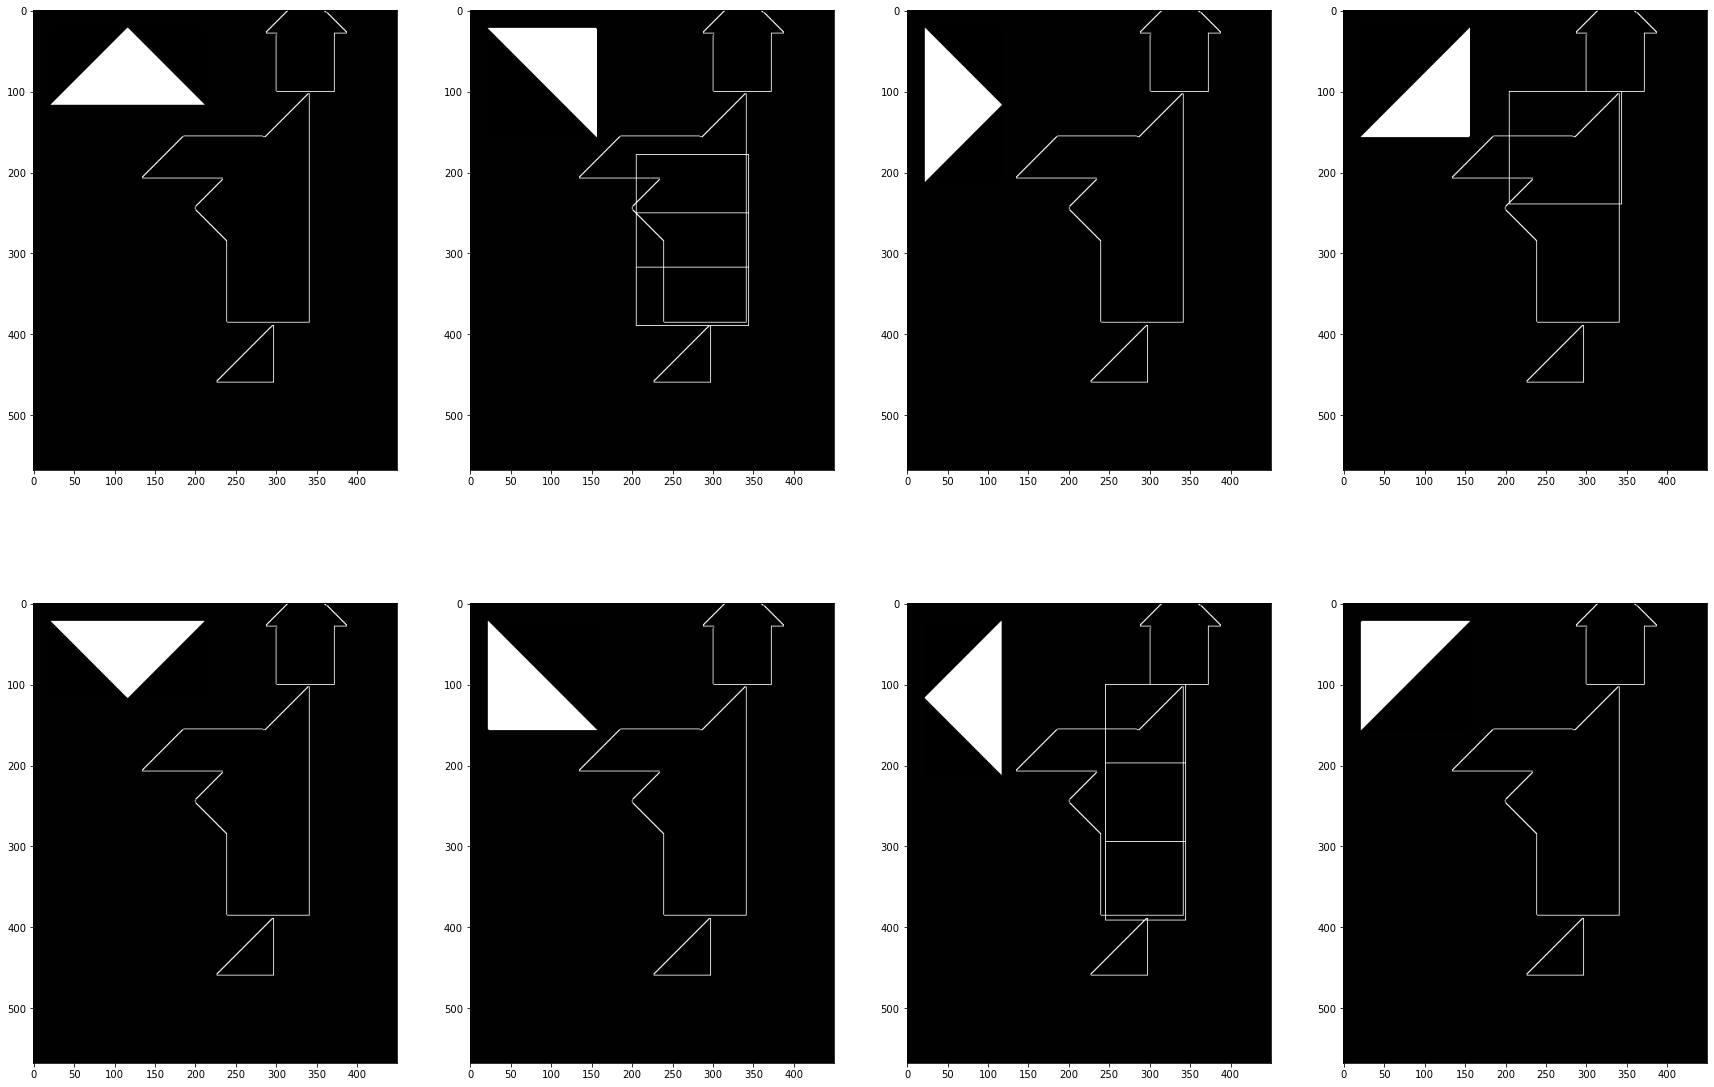

In [99]:
av = show_extracted('./../puzzle_state.png','bigt')

In [7]:
solution_limits = {1: [(-260, 120), (-120, 140)], 2: [(-280, -20), (-80, 200)], 3: [(-320, 60), (-140, 140)],
                   4: [(-280, 0), (-200, 300)]}

def get_grid_value(rm, cm, n, tgn):
    '''
    Converts x and y matrix coordinates into grid values for tangram puzzle = tgn

    :param rm: row value in matrix coordinates
    :type rm: int
    :param cm: column value in matrix coordinates
    :type cm: int
    :param n: grid size
    :type n: int
    :return:  grid number 0-15, or -1 if outside the grid
    '''

    y = -rm + 300
    x = cm - 400

    xrange = solution_limits.get(tgn)[0]
    yrange = solution_limits.get(tgn)[1]
    xstep = (xrange[1] - xrange[0]) / n
    ystep = (yrange[1] - yrange[0]) / n
    if (x not in range(xrange[0], xrange[1] + 1) or y not in range(yrange[0], yrange[1] + 1)):
        return -1
    xgrid = (x - xrange[0]) // xstep

    ygrid = (y - yrange[0]) // ystep

    return x, y, ygrid * n + xgrid

In [17]:
def show_steps(img_path,piece_type):
    piece_counts = pd.read_csv('./../datasets/landmark_str_5.csv')
    piece_counts= piece_counts.loc[piece_counts['tangram nr'] ==4]
    fig,axs = plt.subplots(1,4)
    fig.set_figheight(20)
    fig.set_figwidth(30)
    
    
    img = cv.imread(img_path,0)
    img = img[31:-1,1:-1]
    img[500:,:] = 0
    img = img [:,:450]
    axs.ravel()[0].imshow(img, cmap= 'gray')
    axs.ravel()[0].set_title('Puzzle state after first action',fontsize= 'xx-large')
    trhesh,img = cv.threshold(img, 240,1, cv.THRESH_BINARY)
    
    
    template = cv.imread(f"./tans/{piece_type}.png",0)
    template = template[3:,3:]
    t2,template = cv.threshold(template, 100,1, cv.THRESH_BINARY)
    #template = ndimage.rotate(template, 45)
    
    nonzero = template.nonzero()
    
    #creating the proper templates at rotations
    current = template[min(nonzero[0]) - 2:max(nonzero[0]) + 2, min(nonzero[1]) - 2:max(nonzero[1]) + 2]
    
    available_placements =[]
        
    image_edges = cv.Canny(img*255,100,200)
    axs.ravel()[1].imshow(image_edges, cmap= 'gray')
    axs.ravel()[1].set_title('Extracting silhouette edges', fontsize ='xx-large')
    template_edges = cv.Canny(current*255,100,200)
    h, w = current.shape[:2]

    method = cv.TM_SQDIFF

    res = cv.matchTemplate(image_edges, template_edges, method, mask=  current)

    i=0
    attempt =0    
    rectangles = []
    while i < 5 and attempt <7:
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)

        xt = min_loc[1] - h // 2 if min_loc[1] > 20 else 0
        xb = min_loc[1] + h // 2 + 1
        yl = min_loc[0] - w // 2 if min_loc[0] > 20 else 0
        yr = min_loc[0] + w // 2 + 1

        res[xt:xb, yl:yr] = float('inf')

        part = img[min_loc[1]:min_loc[1] + h, min_loc[0]:min_loc[0] + w]
        
        if np.count_nonzero(np.bitwise_xor(np.bitwise_and(part, current), current)) < 50:
            rectangles.append((min_loc[0],min_loc[1]))
            #
            
            central_coord = (min_loc[1] + h // 2, min_loc[0] + w // 2)
            available_placements.append((get_grid_value(central_coord[0],central_coord[1], 5, 4)[2],0))
            i+=1

        attempt+=1
    
    
    image_edges[20:20+h,20:20+w]=current*255 
    
    
    piece_landmarks =[]
    
    im2 = np.copy(image_edges)
    im3 = np.copy(image_edges)
    
    for i in range(len(available_placements)):
        p = available_placements[i]
        (x,y) = rectangles[i]
        cv.rectangle(im2,(x,y), (x+w+1, y+h+1), (255,255,255),3 )
        
        row = piece_counts.loc[(piece_counts['grid_val'] == int(p[0])) & \
                                               (piece_counts['rot'] == p[1])]
        if not row.empty:
            
            cv.rectangle(im3,(x,y), (x+w+1, y+h+1),(255,255,255),3)
            piece_landmarks.append((p,row['strength'].values[0]))
 
    ax_img=axs.ravel()[2].imshow(im2,cmap='gray')
    axs.ravel()[2].set_title('Pattern matching results', fontsize='xx-large')
    ax_img=axs.ravel()[3].imshow(im3,cmap='gray')
    axs.ravel()[3].set_title('After intersecting with data',fontsize='xx-large')
    print(available_placements)
    print(piece_landmarks)

[(11.0, 0), (8.0, 0), (23.0, 0)]
[((23.0, 0), 0.1913043478260869)]


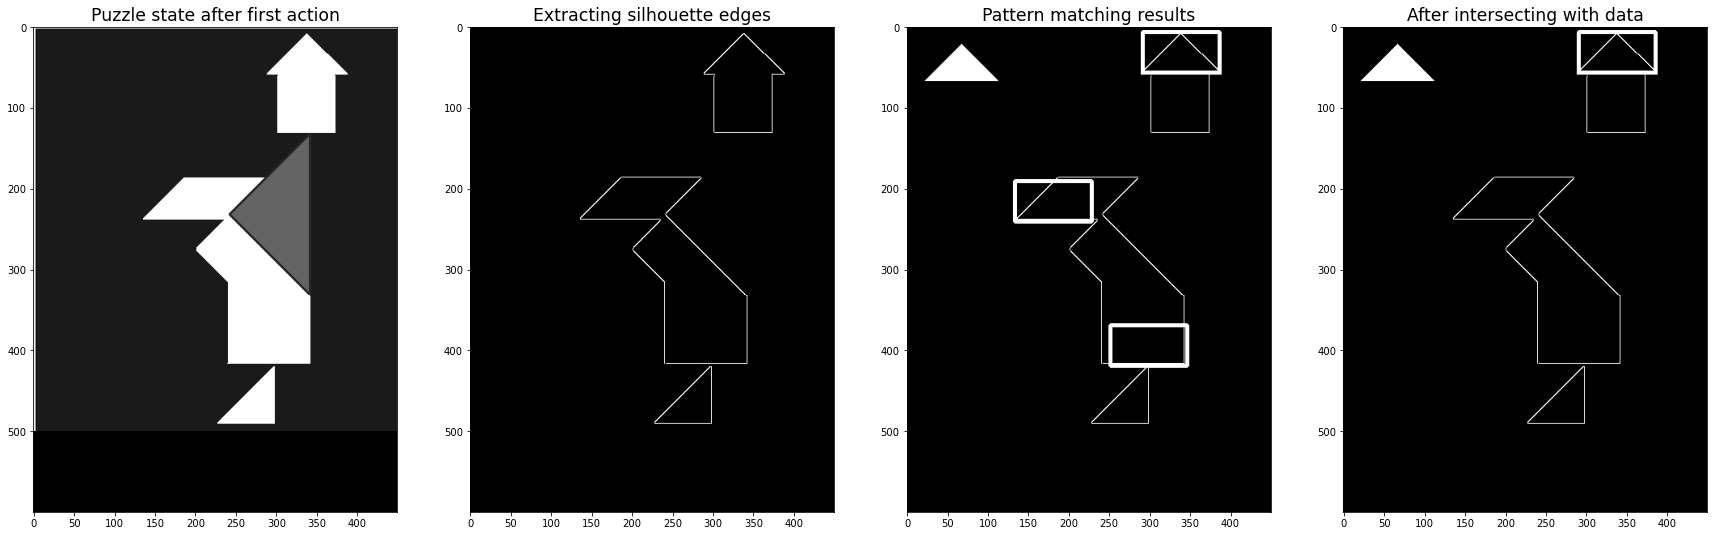

In [18]:
show_steps('./example_pictures/2.png','smallt')


(0, 0)
(48, 0)
(96, 0)
(144, 0)
(192, 0)
(240, 0)
(288, 0)
(336, 0)
(0, 25)
(48, 25)
0.00894927978515625
[]


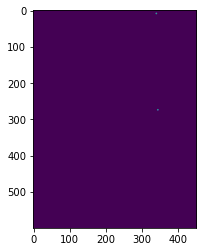

In [6]:
#img = cv.imread('./../puzzle_state.png',0)
#img = cv.imread('./example_pictures/from_app.png',0)
img = cv.imread('./../utility_pictures/thresholded.png',0)
#trhesh,img = cv.threshold(img, 240,1, cv.THRESH_BINARY)
#img = img[31:-1,1:-1]
#img[500:,:] = 0
img = img [:,:450]
plt.imshow(img*255,cmap = 'gray')
img.shape

##templates
name = 'smallt'
template = cv.imread(f"./tans/{name}.png",0)
template = template[3:,3:]
t2,template = cv.threshold(template, 100,1, cv.THRESH_BINARY)
plt.imshow(template*255,cmap='gray')

nonzero = template.nonzero()
templates = [template[min(nonzero[0]) - 2:max(nonzero[0]) + 2, min(nonzero[1]) - 2:max(nonzero[1]) + 2]]
for r in range(-45,-325,-45):
    rotated= ndimage.rotate(template,r)
    nonzero = rotated.nonzero()
    rotated= rotated[min(nonzero[0])-2:max(nonzero[0])+2,min(nonzero[1])-2:max(nonzero[1])+2]
    templates.append(rotated)

available_placements =[]
start = time.time()
current = templates[0]
edges = cv.Canny(current*255,100,200)


edged_img = cv.Canny(img,100,200)
image = cv.Canny(img*255,100,200)

h, w = current.shape[:2]

method = cv.TM_SQDIFF

#res = cv.matchTemplate(image, edges, method, mask=  current)
res = cv.matchTemplate(image, edges, method)

i=0
attempt =0
while i < 4 and attempt < 10:
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)

    xt = min_loc[1]-h//2 if min_loc[1]>20 else 0
    xb = min_loc[1]+h//2+1
    yl = min_loc[0]-w//2 if min_loc[0]>20 else 0
    yr = min_loc[0]+w//2+1

    res[xt:xb,yl:yr] = float('inf')

    central_coord = (min_loc[1]+h//2,min_loc[0]+w//2)
#     if (img[central_coord] ==1):
#         #print((min_loc[1]+h//2,min_loc[0]+w//2))
#         cv.rectangle(image,(min_loc[0],min_loc[1]), (min_loc[0]+w+1, min_loc[1]+h+1), 255 )
    print(min_loc)
    part =  img[min_loc[1]:min_loc[1]+h,min_loc[0]:min_loc[0]+w]
    #print(np.count_nonzero(np.bitwise_and(part,current)-current))
    if np.count_nonzero(np.bitwise_and(part,current)-current) <100 :
        
        cv.rectangle(image,(min_loc[0],min_loc[1]), (min_loc[0]+w+1, min_loc[1]+h+1), 255 )

        #available_placements.append((central_coord,ti*45))
        available_placements.append(min_loc)
        i+=1
    #ax.imshow(image,cmap='gray')
    attempt+=1
print(time.time()-start)
print(available_placements)
plt.imshow(edged_img)

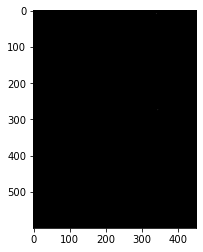

In [4]:
img = cv.imread('./../utility_pictures/thresholded.png',0)
trhesh,img = cv.threshold(img, 240,1, cv.THRESH_BINARY)
plt.imshow(img*255,cmap = 'gray')
img.shape

##templates
name = 'middlet'
template = cv.imread(f"./tans/{name}.png",0)
template = template[3:,3:]
t2,template = cv.threshold(template, 100,1, cv.THRESH_BINARY)


nonzero = template.nonzero()
small_t_templates = [template[min(nonzero[0]) - 2:max(nonzero[0]) + 2, min(nonzero[1]) - 2:max(nonzero[1]) + 2]]
for r in range(-45,-325,-45):
    rotated= ndimage.rotate(template,r)
    nonzero = rotated.nonzero()
    rotated= rotated[min(nonzero[0])-2:max(nonzero[0])+2,min(nonzero[1])-2:max(nonzero[1])+2]
    small_t_templates.append(rotated)


0.1544816493988037
[]


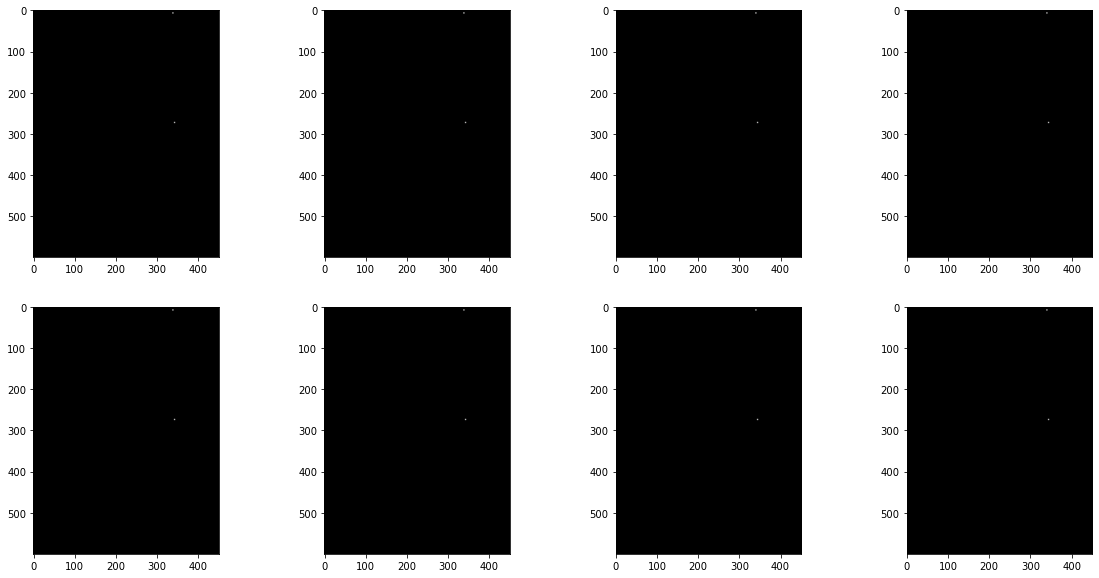

In [5]:
fig,axs = plt.subplots(2,4)
fig.set_figheight(10)
fig.set_figwidth(20)
available_placements =[]
start = time.time()
for ti,ax in zip(range(len(small_t_templates)),axs.ravel()):
#for ti in range(len(small_t_templates)):
    current = small_t_templates[ti]
    edges = cv.Canny(current*255,100,200)
    image = cv.Canny(img*255,100,200)

    h, w = current.shape[:2]

    method = cv.TM_SQDIFF



    #res = cv.matchTemplate(image, edges, method, mask=  current)    
    res = cv.matchTemplate(image, edges, method)
    
    i=0
    attempt =0
    while i < 4 and attempt < 10:
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
        
        xt = min_loc[1]-h//2 if min_loc[1]>20 else 0
        xb = min_loc[1]+h//2+1
        yl = min_loc[0]-w//2 if min_loc[0]>20 else 0
        yr = min_loc[0]+w//2+1
        
        res[xt:xb,yl:yr] = float('inf')
        
        central_coord = (min_loc[1]+h//2,min_loc[0]+w//2)
#         if (img[central_coord] ==1):
#             #print((min_loc[1]+h//2,min_loc[0]+w//2))
#             cv.rectangle(image,(min_loc[0],min_loc[1]), (min_loc[0]+w+1, min_loc[1]+h+1), 255 )
        part =  img[min_loc[1]:min_loc[1]+h,min_loc[0]:min_loc[0]+w]
        if np.count_nonzero(np.bitwise_xor(np.bitwise_and(part,current),current)) <50 :

            cv.rectangle(image,(min_loc[0],min_loc[1]), (min_loc[0]+w+1, min_loc[1]+h+1), 255 )

                
            available_placements.append((central_coord,ti*45))
            i+=1
        ax.imshow(image,cmap='gray')
        attempt+=1
print(time.time()-start)
print(available_placements)

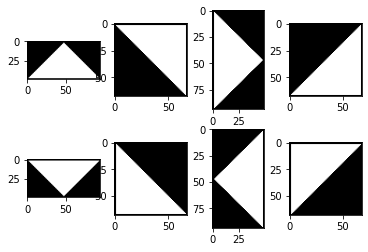

In [46]:
fig,axs = plt.subplots(2,4)
for ti,ax in zip(range(len(small_t_templates)),axs.ravel()):
    ax.imshow(small_t_templates[ti],cmap='gray')

65025.0
(305, 63)
65025.0
(274, 348)
4356675.0
(233, 60)


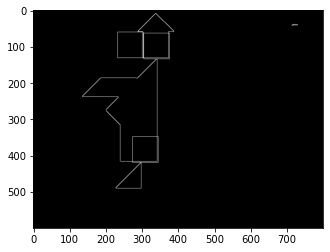

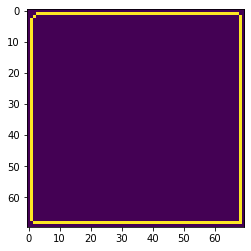

In [64]:
name = 'square'
template = cv.imread(f"./tans/{name}.png",0)
t2,template = cv.threshold(template, 100,1, cv.THRESH_BINARY)
plt.imshow(template*255,cmap='gray')

nonzero = template.nonzero()
current = template[min(nonzero[0]) - 2:max(nonzero[0]) + 2, min(nonzero[1]) - 2:max(nonzero[1]) + 2]
#current = template
edges = cv.Canny(current*255,100,200)
img = cv.imread('./example_pictures/1.png',0)
trhesh,img = cv.threshold(img, 240,1, cv.THRESH_BINARY)
img = img[31:-1,1:-1]
img[500:,:] = 0
image = cv.Canny(img*255,100,200)
#
#image =img.copy()

h, w = current.shape[:2]

method = cv.TM_SQDIFF



res = cv.matchTemplate(image, edges, method, mask=  current)
#res = cv.matchTemplate(image, current, method)
# fake out max_val for first run through loop
min_val = 1
for i in range(3):
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    print(min_val)
    print(min_loc)
         
    xt = min_loc[1]-h//2 if min_loc[1]>20 else 0
    xb = min_loc[1]+h//2+1
    yl = min_loc[0]-w//2 if min_loc[0]>20 else 0
    yr = min_loc[0]+w//2+1
    #res[max_loc[1]-h//2:max_loc[1]+h//2+1, max_loc[0]-w//2:max_loc[0]+w//2+1] = 0 
    res[xt:xb,yl:yr] = float('inf') 
    cv.rectangle(image,(min_loc[0],min_loc[1]), (min_loc[0]+w+1, min_loc[1]+h+1), 255 )
        

plt.figure(0)
plt.imshow(image,cmap='gray')
plt.figure(1)
plt.imshow(edges)

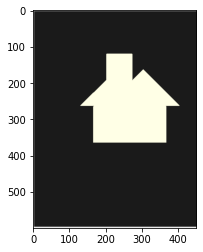

In [6]:
grid_img = plt.imread('./example_pictures/start_p2.png',0)
grid_img = grid_img[:,:450]
plt.imshow(grid_img)

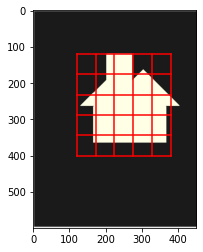

In [14]:
#sl = [(-280,0),(-200,300)]

# y = -rm + 300
# x = cm - 400

cmin = 120
cmax= 380
rmin = 120
rmax = 400
# s2 = [(-280, -20), (-80, 200)]
plt.imshow(grid_img)
for i in range(6):
    plt.plot([cmin+i*52,cmin+i*52],[rmin,rmax],'r')
for j in range(6):
    plt.plot([cmin,cmax],[rmin+j*56,rmin+j*56],'r')
    

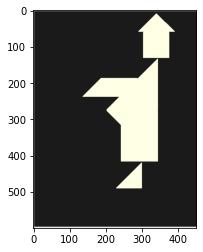

In [28]:
grid_img = plt.imread('./example_pictures/puzzle_state_start.png',0)
grid_img = grid_img[:,:450]
for i in range(6):
    #plt.plot([cmin+i*56,cmin+i*56],[0,500],'r')
    cv.line(grid_img,[cmin+i*56,0],[cmin+i*56,0],color = (0.5))
# for j in range(6):
#     plt.plot([cmin,cmax],[0+j*100,0+j*100],'r')
plt.imshow(grid_img)

In [ ]:
p